# An analysis of the State of the Union speeches - Part 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve
import nltk
from nltk.stem import PorterStemmer

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [2]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [3]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [4]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

We start off by creating a clean word tokenizer that tokenizes speeches, removes stop words and punctuations and turns everything lowercase. 

In [5]:
from nltk.corpus import stopwords
import string

def clean_word_tokenize(doc):
    """custom word tokenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    # combine stop words and punctuations
    stop = stopwords.words("english") + list(string.punctuation)
    
    # filter out stop words and punctuation and send each token to lower case
    tokens = [token.lower() for token in nltk.word_tokenize(doc) if token not in stop]

    return(tokens)   #return a list of cleaned words
    

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [6]:
#We'll create a few helper lists of lists so we don't have to keep rerunning the for loops through the set of speeches

#speeches_cleaned is a list of lists that contains all cleaned words for each speech (not stemmed, not unique)
speeches_cleaned = [clean_word_tokenize(speech) for speech in speeches]

#We'll be using the PorterStemmer to stem our words
stemmer = PorterStemmer()

#speech_words is a list of lists that contains the set of unique, stemmed words for each speech
speech_words = [set(stemmer.stem(word) for word in speech) for speech in speeches_cleaned]

Using our helper lists we add more information about each speech to the addresses dataframe.

In [7]:
#Let's add # of sentences in each speech to addresses  
addresses['n_sent'] = [len(nltk.sent_tokenize(speech)) for speech in speeches]

#Let's add # of total words in each speech to addresses 
addresses['n_words_all'] = [len(nltk.word_tokenize(speech)) for speech in speeches]

#Let's add # of cleaned words in each speech to addresses 
addresses['n_words'] = [len(speech) for speech in speeches_cleaned]

#Let's add # of unique cleaned words in each speech to addresses 
addresses['n_uwords'] = [len(set(speech)) for speech in speeches_cleaned]

#Let's add # of unique stemmed cleaned words in each speech to addresses 
addresses['n_swords'] = [len(speech) for speech in speech_words]

#Finally let's add # characters in each speech to addresses
addresses['n_chars'] = [len(speech) for speech in speeches]                             

Let's look at a summary of these 

In [8]:
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24,1178,538,395,356,6753
1,George Washington,State of the Union Address,1790-12-08,40,1515,683,513,463,8455
2,George Washington,State of the Union Address,1791-10-25,60,2487,1136,731,626,14203
3,George Washington,State of the Union Address,1792-11-06,61,2298,1042,682,580,12764
4,George Washington,State of the Union Address,1793-12-03,56,2132,972,714,652,11696


We can quickly obtain summary statistics on each new column to get an idea of each column's distribution amongst all speeches.

In [9]:
pd.options.display.precision = 2
dists = addresses.describe()
dists

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1639.84,1290.51,45473.15
std,178.80,5871.69,2900.51,747.67,508.09,33020.36
min,24.00,1059.00,538.00,395.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1088.50,914.50,23394.50
50%,240.00,6655.00,3388.00,1530.00,1246.00,36677.00
75%,347.50,10055.00,4801.50,1998.50,1552.00,55211.00
max,1343.00,36974.00,21041.00,4282.00,3015.00,218009.00


The standard deviations of sentences and cleaned words is 70% of their means which implies there is a large range of sentence length and word length amongst speeches. Let's actually visualize these distributions to be able to esily compare between the different features. 

(0, 4668.3937873125733)

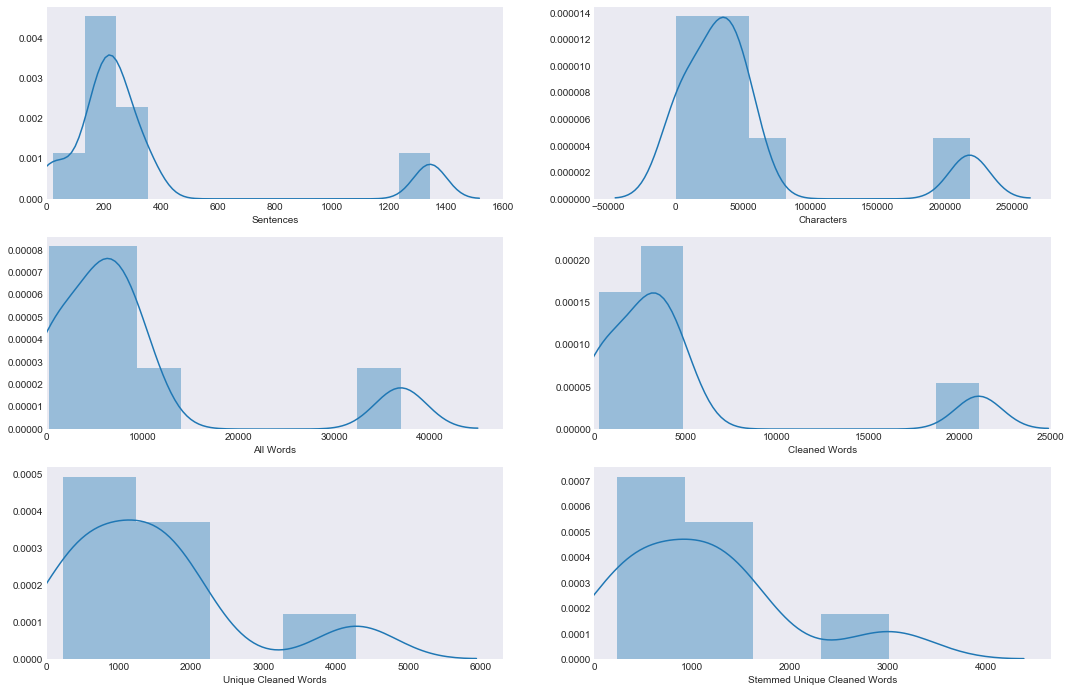

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 12), nrows =3 , ncols = 2)
sns.distplot(dists['n_sent'], ax = ax1[0]);
ax1[0].set_xlabel('Sentences')
ax1[0].set_xlim(0, )

sns.distplot(dists['n_chars'], ax = ax1[1]);
ax1[1].set_xlabel('Characters')
ax2[1].set_xlim(0, )

sns.distplot(dists['n_words_all'], ax = ax2[0]);
ax2[0].set_xlabel('All Words')
ax2[0].set_xlim(0, )

sns.distplot(dists['n_words'], ax = ax2[1]);
ax2[1].set_xlabel('Cleaned Words')
ax2[1].set_xlim(0, 25000)

sns.distplot(dists['n_uwords'], ax = ax3[0]);
ax3[0].set_xlabel('Unique Cleaned Words')
ax3[0].set_xlim(0, )

sns.distplot(dists['n_swords'], ax = ax3[1]);
ax3[1].set_xlabel('Stemmed Unique Cleaned Words')
ax3[1].set_xlim(0, )

All features are bimodal which explains why we are seeing such large standard deviations. Overall it seems like most speeches are fairly short (around 4000 cleaned words) but there are a couple of speeches that are extremely long (close to 20,000 cleaned words). Let's examine if there is change in speech length over time. 

## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

Before plotting, we'll create series variables for each of features so they are eaiser to work with and faster to plot. 

In [11]:
#Create series for each feature with date indexes
sents = pd.Series(list(addresses.n_sent), index = addresses.date)
all_words = pd.Series(list(addresses.n_words_all), index = addresses.date)
clean_words = pd.Series(list(addresses.n_words), index = addresses.date)
unq_stem_clean_words= pd.Series(list(addresses.n_swords), index = addresses.date)
char = pd.Series(list(addresses.n_chars), index = addresses.date)

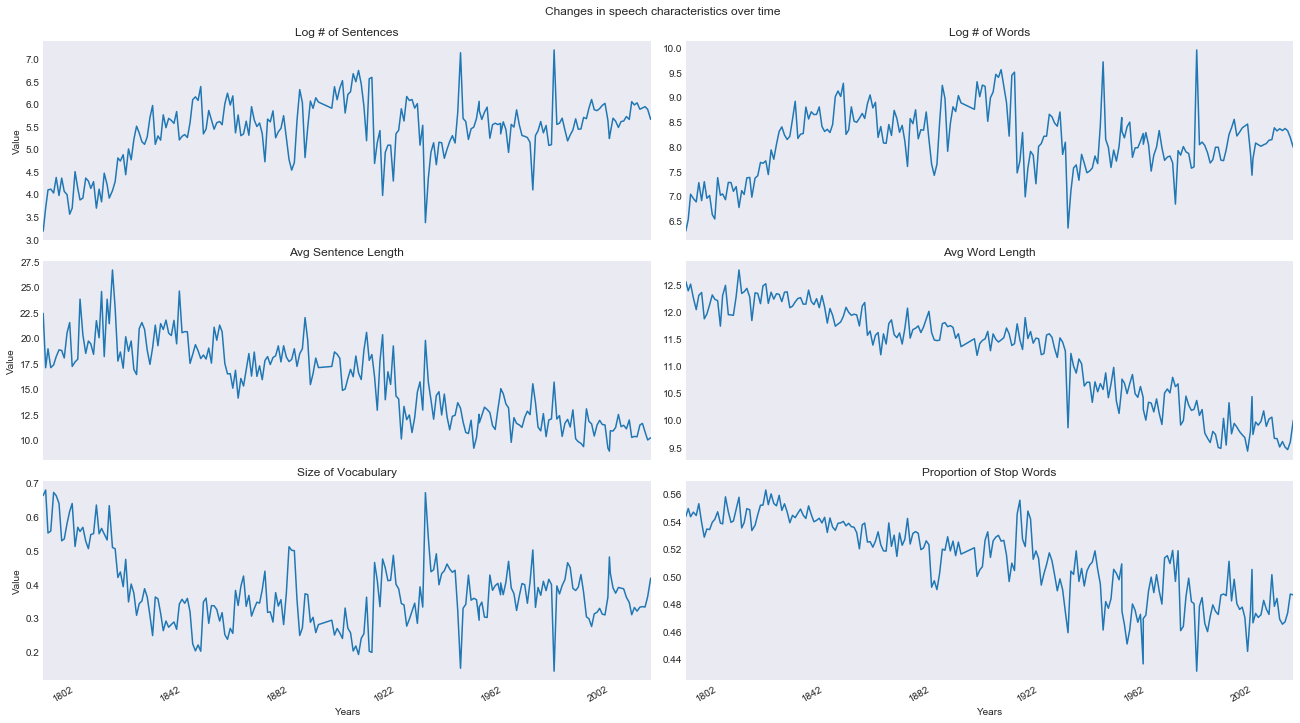

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 12), nrows = 3, ncols = 2)
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('Changes in speech characteristics over time')

#Plot the log(# of sentences)
np.log(sents).plot(ax = ax1[0])
ax1[0].set_title('Log # of Sentences')
ax1[0].xaxis.set_visible(False)
ax1[0].set_ylabel('Value')

#Plot the log(# of cleaned words)
np.log(clean_words).plot(ax = ax1[1])
ax1[1].set_title('Log # of Words')
ax1[1].xaxis.set_visible(False)

#Plot the average # of words in each sentence (or average sentence length)
(clean_words/sents).plot(ax = ax2[0])
ax2[0].set_title('Avg Sentence Length')
ax2[0].xaxis.set_visible(False)
ax2[0].set_ylabel('Value')

#Plot the average # of characters in each word (or average word length)
(char/clean_words).plot(ax = ax2[1])
ax2[1].set_title('Avg Word Length')
ax2[1].xaxis.set_visible(False)

#Plot the proportion of stemmed, unique word over the total # of cleaned word (Vocabulary Size)
(unq_stem_clean_words/clean_words).plot(ax = ax3[0])
ax3[0].set_title('Size of Vocabulary')
ax3[0].set_ylabel('Value')
ax3[0].set_xlabel('Years')

#Plot the proportion of stop words and punctuation over all words (Proportion of Stop Words)
((all_words - clean_words)/all_words).plot(ax = ax3[1])
ax3[1].set_title('Proportion of Stop Words')
ax3[1].set_xlabel('Years')

#Save our plots as pngs in the fig directory
plt.savefig("fig/speech_changes.png")

Log # of Sentences and Log # of Words show very similar patterns over time. It seems like the eariler president from 1790 to about 1820 just have shorter speeches with fewer sentences ad fewer words. Since 1820, speech lengths have fluctuated but remained around the same at approximately 244 sentences (or 5.5 log sentences) and 2,980 words (8.0 log words). There are 2 large drops and 2 large peaks on both the Log # of Sentences and Log # of Words graphs which signifiy extremely long addresses or extremely short addresses. 

Both the Avg Sentence Length and Avg Word Length graphs show a declining trend over time. Around the late 18th century/early 19th century sentences were around 20-25 words long and today sentences are only 10-12 words long. For words, the change is less drastic, going from 12 characters per word in the 1800s down to 10 characters per word today. 

Size of Vocabulary, which is the proportion of unique words over total words), dropped significantly from 1790 to around 1842 and sine then has fluctuated but remained steady at a proportion of about 0.4 meaning each unique word is repeated around 2.5 times during a speech. 

Proportion of Stop Words has slightty fallen over time from a proporiton of 0.55 in the early 1800s to 0.48 today. This is really interesting because sentence length has decreased over time and # of sentences has remained fairly steady so we might predict that the proportion of stop words to total words would have increased over time but that doesn't seem to be the case.

Now for the distributions by president

We'll create the same series of features as above for the same reason but this time with president names as the indexes.

In [16]:
#Create series for each feature but this time with president names as indexes
p_sents = pd.Series(list(addresses.n_sent), index = addresses.president)
p_all_words = pd.Series(list(addresses.n_words_all), index = addresses.president)
p_clean_words = pd.Series(list(addresses.n_words), index = addresses.president)
p_unq_stem_clean_words= pd.Series(list(addresses.n_swords), index = addresses.president)
p_char = pd.Series(list(addresses.n_chars), index = addresses.president)

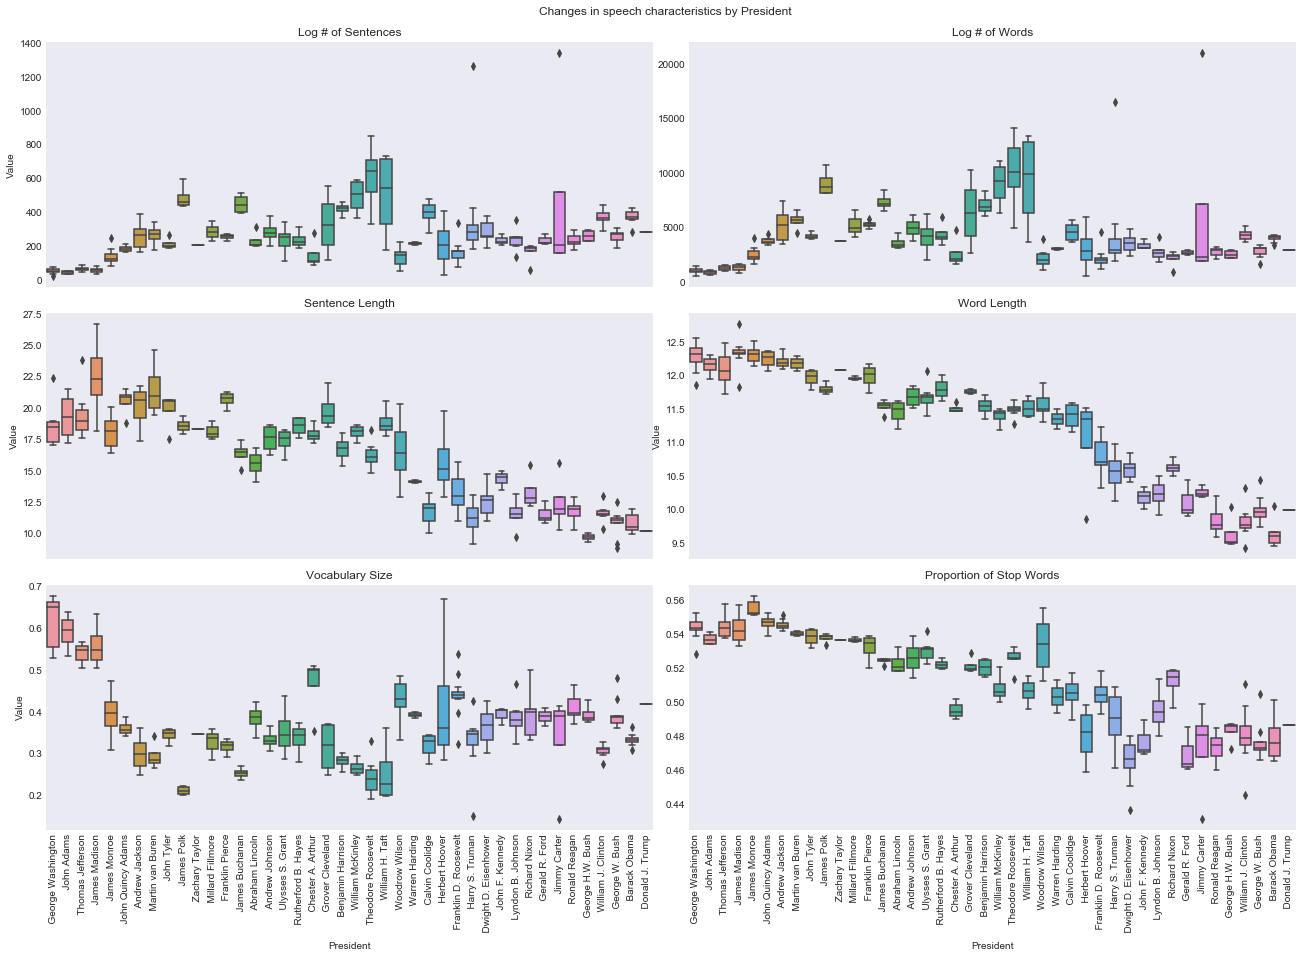

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 12), nrows = 3, ncols = 2)
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('Changes in speech characteristics by President')

#Plot the distribution of log(# of sentences) by president
sns.boxplot(y=p_sents, x=p_sents.index, ax = ax1[0]);
ax1[0].xaxis.set_visible(False)
ax1[0].set_ylabel('Value')
ax1[0].set_title('Log # of Sentences')

#Plot the distribution of log(# of words) by president
sns.boxplot(y=p_clean_words, x=p_clean_words.index, ax = ax1[1]);
ax1[1].xaxis.set_visible(False)
ax1[0].set_ylabel('Value')
ax1[1].set_title('Log # of Words')

#Plot the distribution of sentence length by president
sns.boxplot(y=(p_clean_words/p_sents), x=p_sents.index, ax = ax2[0]);
ax2[0].xaxis.set_visible(False)
ax2[0].set_ylabel('Value')
ax2[0].set_title('Sentence Length')

#Plot the distribution of word length by president
sns.boxplot(y=(p_char/p_clean_words), x=p_clean_words.index, ax = ax2[1]);
ax2[1].xaxis.set_visible(False)
ax2[1].set_ylabel('Value')
ax2[1].set_title('Word Length')

#Plot the distribution of vocabulary size by president
sns.boxplot(y=(p_unq_stem_clean_words/p_clean_words), x=p_clean_words.index, ax = ax3[0]);
ax3[0].set_ylabel('Value')
ax3[0].set_title('Vocabulary Size')
ax3[0].set_xticklabels(ax3[0].get_xticklabels(),rotation=90)
ax3[0].set_xlabel('President')

#Plot the distribution of stop words proportion by president
sns.boxplot(y=((p_all_words - p_clean_words)/p_all_words), x=p_all_words.index, ax = ax3[1]);
ax3[1].set_title('Proportion of Stop Words')
ax3[1].set_xticklabels(ax3[1].get_xticklabels(),rotation=90)
ax3[1].set_xlabel('President')

plt.savefig("fig/speech_characteristics.png");

Looking at Log # of Sentences and Log # of Words it seems like most presidents tend to a consistent speaking style.  Some presidents like Washington tend to give short speeches than other presidents like James Buchanan but in general most presidents speeches are within a 100 sentences or 2500 words of each other. Six presidents, Cleveland, McKinley, Roosevelt, Taft, Hoover and Carter have larger ranges of speech lengths than most presidents. Also both Truman and Carter delivered one extremely long address that is displayed as an extreme outlier in their boxplots.

Also while sentence length varies significantly for some presidents, word lenth is fairly consistent for all presidents. It seems like while presidents may vary the length of their speeches or even the length of their sentences, they tend to use the same size words across speeches.

Presidents Washington, Adams, Jefferson, and Madison have a larger vocabulary size across their speeches as any other president. President Hoover has a huge range of vocabulary size amongst his speeches.

Presidents until Cleveland have a narrow range of stop word proportions. Presidents after Cleveland tend to have a larger range of stop word proportions across speeches which Jayes and Wilson having the greatest variety. 


## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [18]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words
    db['speeches_cleaned'] = speeches_cleaned